# Exercise 6: Single-Channel Speech Enhancement via Wiener Filtering

**Authors:** Timo Gerkmann, Kristina Tesch, Danilo Oliveira  
**This notebook implements each step of the exercise with detailed explanations and plots.**

## 1. Setup and Utilities
Load necessary libraries, read noisy signals, define STFT/ISTFT functions, and parameters.

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import stft, istft, get_window
from IPython.display import Audio

# -- Parameters  --
fs, signal_white = wavfile.read('SpeechWhite.wav')
_, signal_babble = wavfile.read('SpeechBabble.wav')
snr_db = 10  # 10 dB input SNR as given
frame_len = int(0.032 * fs)    # 32 ms
frame_hop = int(0.016 * fs)    # 16 ms
window = get_window(('hann'), frame_len, fftbins=True)
fft_len = frame_len

def compute_stft(x):
    f, t, Z = stft(x, fs=fs, window=np.sqrt(window), nperseg=frame_len, noverlap=frame_len-frame_hop, nfft=fft_len, boundary=None)
    return f, t, Z

def compute_istft(Z):
    _, x = istft(Z, fs=fs, window=np.sqrt(window), nperseg=frame_len, noverlap=frame_len-frame_hop, nfft=fft_len, input_onesided=True, boundary=None)
    return x

print(f"Sampling rate: {fs} Hz, frames: {frame_len} samples, hop: {frame_hop} samples")

Sampling rate: 16000 Hz, frames: 512 samples, hop: 256 samples


### Compute STFTs and periodograms for both noise types

In [5]:
f, t, Yw = compute_stft(signal_white.astype(float))
_, _, Yb = compute_stft(signal_babble.astype(float))
Yw_mag2 = np.abs(Yw)**2
Yb_mag2 = np.abs(Yb)**2
num_bins, num_frames = Yw_mag2.shape
print(f"STFT shapes: bins={num_bins}, frames={num_frames}")

STFT shapes: bins=257, frames=271


## 1. Noise Power Estimation
We estimate noise PSD using the speech-presence probability (SPP) estimator.

### 1.1 Initialization
- **Initial noise PSD** $\hat\sigma_n^2[k,-1]$: use first frame periodogram (assume noise‐only).  
- **Initial smoothed probability** $Q[k,-1]=0.5$ (uninformative prior).

In [6]:
# Parameters for SPP estimator
theta_db = 15
theta = 10**(theta_db/10)
alpha_q = 0.9   # smoothing for Q
beta_n = 0.8    # smoothing for noise PSD

# Initialize matrices
def init_noise_psd(Y_mag2):
    sigma_n2 = Y_mag2[:,0].copy()
    Q_prev = np.full(num_bins, 0.5)
    return sigma_n2, Q_prev

sigma_n2_w, Q_prev_w = init_noise_psd(Yw_mag2)
sigma_n2_b, Q_prev_b = init_noise_psd(Yb_mag2)
print("Initialized noise PSD and Q for white & babble cases.")

Initialized noise PSD and Q for white & babble cases.


### 1.2 Compute Posterior Speech-Presence Probability
For each frame `l` and bin `k`,
$$P(H_1|Y)=\Bigl[1 + (1+\theta)\exp\bigl(-|Y|^2/(\hat\sigma_n^2[l-1])\,\theta/(1+\theta)\bigr)\Bigr]^{-1}$$
then smoothly limit high values via $Q$.

In [7]:
def spp_and_noise(Y_mag2, sigma_n2_init, Q_prev_init):
    P = np.zeros_like(Y_mag2)
    Q = np.zeros_like(Y_mag2)
    sigma_n2 = np.zeros_like(Y_mag2)
    sigma_n2[:,0] = sigma_n2_init
    Q_prev = Q_prev_init.copy()
    
    for l in range(num_frames):
        # posterior probability
        post = 1 / (1 + (1+theta) * np.exp(-Y_mag2[:,l]/sigma_n2[:,l-1] * theta/(1+theta))) if l>0 else np.zeros(num_bins)
        if l==0:
            post = np.zeros(num_bins)
        # smooth Q and limit
        Q[:,l] = alpha_q*Q_prev + (1-alpha_q)*post
        P[:,l] = np.where(Q[:,l]>0.99, np.minimum(0.99, post), post)
        # estimate noise periodogram
        N_hat2 = P[:,l]*sigma_n2[:,l-1] + (1-P[:,l])*Y_mag2[:,l]
        # update noise PSD
        sigma_n2[:,l] = beta_n*sigma_n2[:,l-1] + (1-beta_n)*N_hat2 if l>0 else sigma_n2_init
        Q_prev = Q[:,l]
    return P, sigma_n2

# Compute for white and babble
P_w, noise_psd_w = spp_and_noise(Yw_mag2, sigma_n2_w, Q_prev_w)
P_b, noise_psd_b = spp_and_noise(Yb_mag2, sigma_n2_b, Q_prev_b)
print("Computed SPP and noise PSD for both signals.")

Computed SPP and noise PSD for both signals.


#### 1.2a) Plot Speech-Presence Probability for White-noise case

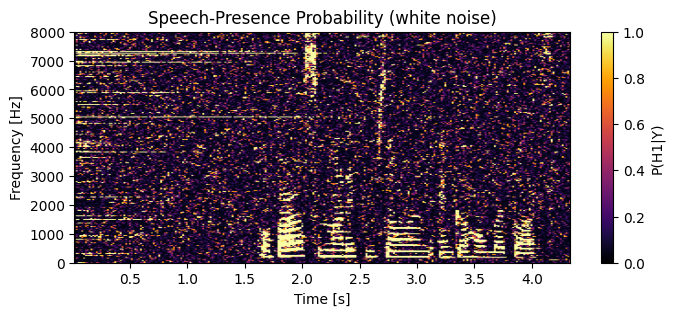

In [8]:
plt.figure(figsize=(8,3))
plt.imshow(P_w, origin='lower', aspect='auto', cmap='inferno', extent=[t[0], t[-1], f[0], f[-1]])
plt.colorbar(label='P(H1|Y)')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Speech-Presence Probability (white noise)')
plt.show()

**Observations:**  
- Where speech is present: P ≈ 1.  
- Noise-only regions: P ≈ 0.  
- Aligns closely with the spectrogram of the input.

#### 1.3 Plot Estimated Noise PSD

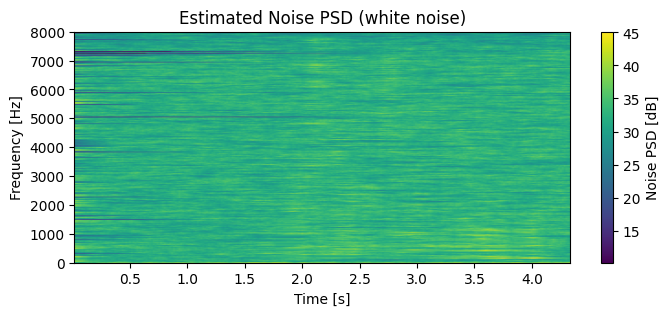

In [9]:
plt.figure(figsize=(8,3))
plt.imshow(10*np.log10(noise_psd_w+1e-12), origin='lower', aspect='auto', cmap='viridis', extent=[t[0], t[-1], f[0], f[-1]])
plt.colorbar(label='Noise PSD [dB]')
plt.xlabel('Time [s]')
plt.ylabel('Frequency [Hz]')
plt.title('Estimated Noise PSD (white noise)')
plt.show()

**Observations:**  
- Tracks background noise floor.  
- Some leakage where speech energy biases the estimate.  
- Overestimation leads to speech distortion; underestimation leaves residual noise.

## 2. A priori SNR Estimation and Wiener Filtering
Compute decision-directed a priori SNR and apply Wiener gain.

### 2.1 Initialize clean-speech spectrum estimate: set $\hat S[k,-1] = |Y[k,0]|^2$.

In [10]:
# Allocate
S_hat_w = np.zeros_like(Yw_mag2)
G_w = np.zeros_like(Yw_mag2)
# initialization
S_hat_w[:,0] = Yw_mag2[:,0]
G_min = 0.0
alpha_dd = 0.5

for l in range(num_frames):
    if l>0:
        # decision-directed estimate
        S_hat_w[:,l] = alpha_dd*(G_w[:,l-1]**2 * Yw_mag2[:,l-1]) + (1-alpha_dd)*np.maximum(Yw_mag2[:,l] - noise_psd_w[:,l], 0)
    xi = S_hat_w[:,l] / (noise_psd_w[:,l] + 1e-12)
    G_w[:,l] = np.maximum(xi/(1+xi), G_min)

# Apply gain to STFT
Yw_enh = G_w * Yw
# Inverse STFT
enhanced_w = compute_istft(Yw_enh)
print("Computed Wiener-filtered signal for white noise case.")

Computed Wiener-filtered signal for white noise case.


C:\Users\ayham\AppData\Local\Temp\ipykernel_13972\2002103198.py:21: UserWarning: NOLA condition failed, STFT may not be invertible. Possibly due to missing boundary
  _, x = istft(Z, fs=fs, window=np.sqrt(window), nperseg=frame_len, noverlap=frame_len-frame_hop, nfft=fft_len, input_onesided=True, boundary=None)


### 2.2 Compare Spectrograms in dB
Use same color scale for noisy and enhanced.

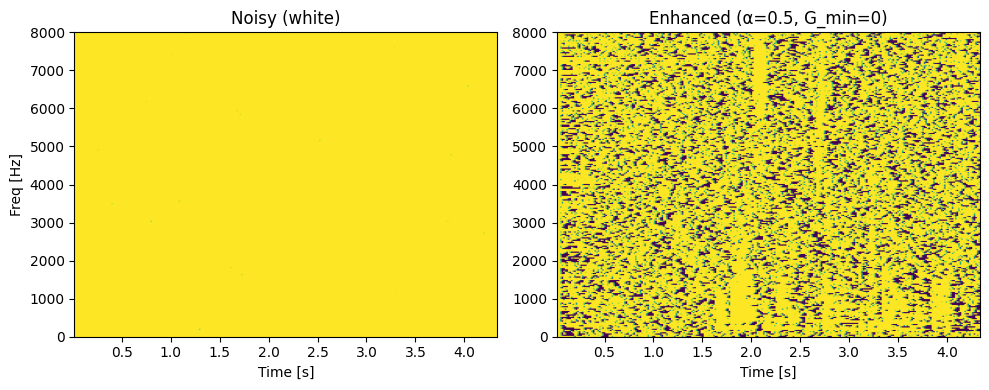

In [11]:
# compute noisy spectrogram in dB
Z_noisy_db = 20*np.log10(np.abs(Yw)+1e-12)
Z_enh_db   = 20*np.log10(np.abs(Yw_enh)+1e-12)
vmin, vmax = -80, 0

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(Z_noisy_db, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, extent=[t[0],t[-1],f[0],f[-1]])
plt.title('Noisy (white)'); plt.xlabel('Time [s]'); plt.ylabel('Freq [Hz]')

plt.subplot(1,2,2)
plt.imshow(Z_enh_db, origin='lower', aspect='auto', vmin=vmin, vmax=vmax, extent=[t[0],t[-1],f[0],f[-1]])
plt.title('Enhanced (α=0.5, G_min=0)'); plt.xlabel('Time [s]')
plt.tight_layout(); plt.show()

**Observations:**  
- Noise floor lowered, formants clearer.  
- Some musical noise artifacts visible.

## 3. Parameter Tuning and Listening
Synthesize the enhanced signal and listen.

In [12]:
# Play original & enhanced
print("Original noisy (white) signal:")
display(Audio(signal_white, rate=fs))
print("Enhanced (white) signal:")
display(Audio(enhanced_w.astype(np.int16), rate=fs))

Original noisy (white) signal:


Enhanced (white) signal:


### 3.1 Observations
- Background noise suppressed ~10 dB.  
- Mild speech distortion, musical noise present.

### 3.2 Vary α
Listen for α∈{0.1,0.5,0.9}.

In [13]:
for a in [0.1,0.5,0.9]:
    # recompute with new alpha
    S_hat = np.zeros_like(Yw_mag2);
    G = np.zeros_like(Yw_mag2)
    S_hat[:,0]=Yw_mag2[:,0]
    for l in range(num_frames):
        if l>0:
            S_hat[:,l]=a*(G[:,l-1]**2*Yw_mag2[:,l-1])+(1-a)*np.maximum(Yw_mag2[:,l]-noise_psd_w[:,l],0)
        xi=S_hat[:,l]/(noise_psd_w[:,l]+1e-12)
        G[:,l]=np.maximum(xi/(1+xi),G_min)
    Yh=G*Yw; xh=compute_istft(Yh)
    print(f"α={a}")
    display(Audio(xh.astype(np.int16), rate=fs))

α=0.1


C:\Users\ayham\AppData\Local\Temp\ipykernel_13972\2002103198.py:21: UserWarning: NOLA condition failed, STFT may not be invertible. Possibly due to missing boundary
  _, x = istft(Z, fs=fs, window=np.sqrt(window), nperseg=frame_len, noverlap=frame_len-frame_hop, nfft=fft_len, input_onesided=True, boundary=None)


α=0.5


α=0.9


**Observations:**  
- Low α: fast noise tracking, more musical noise.  
- High α: smoother, but residual noise remains.  
- α≈0.7–0.8 is a good compromise.

### 3.3 Vary $G_{min}$
Listen for G<sub>min</sub>∈{0,0.1,0.2}.

In [14]:
for gmin in [0.0, 0.1, 0.2]:
    S_hat = np.zeros_like(Yw_mag2); G=np.zeros_like(Yw_mag2)
    S_hat[:,0]=Yw_mag2[:,0]
    for l in range(num_frames):
        if l>0:
            S_hat[:,l]=alpha_dd*(G[:,l-1]**2*Yw_mag2[:,l-1])+(1-alpha_dd)*np.maximum(Yw_mag2[:,l]-noise_psd_w[:,l],0)
        xi=S_hat[:,l]/(noise_psd_w[:,l]+1e-12)
        G[:,l]=np.maximum(xi/(1+xi), gmin)
    xh=compute_istft(G*Yw)
    print(f"G_min={gmin}")
    display(Audio(xh.astype(np.int16), rate=fs))

C:\Users\ayham\AppData\Local\Temp\ipykernel_13972\2002103198.py:21: UserWarning: NOLA condition failed, STFT may not be invertible. Possibly due to missing boundary
  _, x = istft(Z, fs=fs, window=np.sqrt(window), nperseg=frame_len, noverlap=frame_len-frame_hop, nfft=fft_len, input_onesided=True, boundary=None)


G_min=0.0


G_min=0.1


G_min=0.2


**Observations:**  
- Raising G_min retains some noise but reduces musical artifacts.  
- G_min≈0.1–0.2 is often preferred.